In [17]:
import torch
import torch_geometric
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path += ["../test"]

In [3]:
import train_end2end
import graph_data

setGPU: Setting GPU to: 1
torch 1.4.0
torch_geometric 1.3.2


In [4]:
device = torch.device("cuda")

In [48]:
weights = torch.load("../data/PFNet6__npar_5552143__cfg_a8420e1ef2__user_jpata__ntrain_7000__lr_0.0001__1581357310/epoch_70/PFNet6__npar_5552143__cfg_a8420e1ef2__user_jpata__ntrain_7000__lr_0.0001__1581357310.best.pth")

In [49]:
model = train_end2end.PFNet6(15, 512, 14)
model.load_state_dict(weights)

<All keys matched successfully>

In [50]:
model

PFNet6(
  (inp): Sequential(
    (0): Linear(in_features=15, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=512, bias=True)
  )
  (conv1): GATConv(512, 512, heads=4)
  (edgenet): Sequential(
    (0): Linear(in_features=1025, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): LeakyReLU(negative_slope=0.

In [51]:
p = "../data/QCD_run3"
full_dataset = graph_data.PFGraphDataset(root=p)
full_dataset.raw_dir = p
full_dataset.processed_dir = p + "/processed"

In [52]:
pred_ids = []
true_ids = []
pred_momenta = []
true_momenta = []

for i in range(1000):
    d = full_dataset.get(i)
    d.batch = torch.zeros((len(d.x)), dtype=torch.long)
    train_end2end.data_prep(d, device=device)
    edges, cand_id_onehot, cand_momentum = model(d)
    _, pred_id = torch.max(cand_id_onehot, -1)
    pred_ids += [pred_id.detach().cpu().numpy()]
    true_ids += [d.y_candidates_id.detach().cpu().numpy()]
    pred_momenta += [cand_momentum.detach().cpu().numpy()]
    true_momenta += [d.y_candidates.detach().cpu().numpy()]
    
#     cm = sklearn.metrics.confusion_matrix(
#         d.y_candidates_id.detach().cpu().numpy(),
#         pred_id.detach().cpu().numpy()
#     )
    if i%10 == 0:
        print(i, (pred_ids[-1]!=0).sum(), (true_ids[-1]!=0).sum())

0 2470 2467
10 3791 3799
20 2914 2899
30 2859 2879
40 3226 3201
50 2412 2436
60 2671 2685
70 2009 2040
80 2350 2354
90 2419 2420
100 2891 2872
110 3489 3462
120 2831 2835
130 3812 3794
140 2490 2518
150 3062 3070
160 2585 2625
170 2317 2320
180 3214 3194
190 2379 2389
200 2687 2683
210 2836 2832
220 3398 3355
230 2091 2155
240 2938 2960
250 3930 3917
260 2648 2683
270 2853 2862
280 2439 2454
290 3449 3432
300 2677 2667
310 3607 3603
320 3113 3101
330 2717 2736
340 2871 2848
350 2606 2602
360 2429 2430
370 3724 3703
380 3383 3348
390 3197 3170
400 2644 2642
410 2679 2691
420 3160 3187
430 2964 2970
440 3293 3296
450 2353 2359
460 3119 3146
470 2389 2418
480 3799 3752
490 2586 2600
500 2842 2828
510 2818 2864
520 2464 2499
530 2684 2684
540 3429 3464
550 3381 3364
560 3056 3071
570 2745 2765
580 3800 3772
590 2428 2408
600 2600 2586
610 2752 2728
620 3476 3476
630 3399 3387
640 2918 2941
650 2529 2547
660 2119 2130
670 3230 3221
680 2476 2469
690 2875 2884
700 3125 3141
710 2536 2545
720

In [53]:
n_preds = []
n_trues = []
for i in range(len(pred_ids)):
    n_true = np.sum(true_ids[i]!=0)
    n_pred = np.sum(pred_ids[i]!=0)
    n_preds += [n_pred]
    n_trues += [n_true]

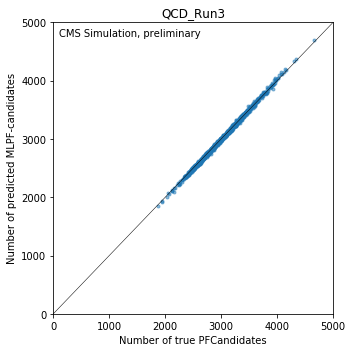

In [54]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.plot([0,5000],[0,5000], color="black", lw=0.5)
plt.scatter(n_trues, n_preds, marker=".", alpha=0.5)
plt.xlim(0,5000)
plt.ylim(0,5000)
plt.xlabel("Number of true PFCandidates")
plt.ylabel("Number of predicted MLPF-candidates")
plt.title("QCD_Run3")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("num_pred.pdf")

In [55]:
cms = []
for i in range(len(pred_ids)):
    cm = sklearn.metrics.confusion_matrix(
        true_ids[i],
        pred_ids[i], labels=range(len(train_end2end.class_labels))
    )
    cms += [cm]
cm = sum(cms)
cm = cm / 1000.0
cm = np.round(cm, 1)#.astype(np.int)

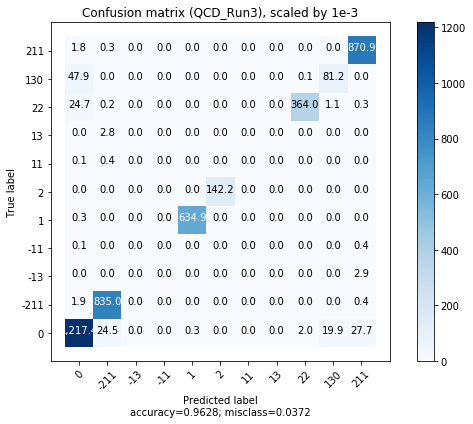

In [56]:
train_end2end.plot_confusion_matrix(cm, [int(x) for x in train_end2end.class_labels], normalize=False)
#plt.xlim(-0.5, 9.5)
#plt.ylim(-0.5, 9.5)
plt.title("Confusion matrix (QCD_Run3), scaled by 1e-3")
#plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
#plt.tight_layout()
plt.savefig("cm.pdf")

In [57]:
pm = np.concatenate(pred_momenta)
tm = np.concatenate(true_momenta)
ti = np.concatenate(true_ids)
pi = np.concatenate(pred_ids)

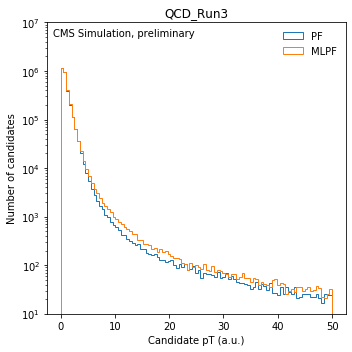

In [58]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(0, 50, 100)
h0 = plt.hist(pm[pi!=0, 0], bins=bins, histtype="step", lw=1, label="PF");
h1 = plt.hist(tm[ti!=0, 0], bins=bins, histtype="step", lw=1, label="MLPF");
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim(10, 1e7)

plt.xlabel("Candidate pT (a.u.)")
plt.ylabel("Number of candidates")
plt.title("QCD_Run3")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("pt_hist.pdf")

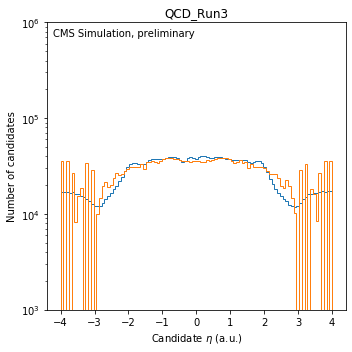

In [59]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

bins = np.linspace(-4, 4, 100)
plt.hist(pm[pi!=0, 1], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 1], bins=bins, histtype="step", lw=1);
plt.yscale("log")

plt.ylim(1000, 1e6)
plt.xlabel("Candidate $\eta$ (a.u.)")
plt.ylabel("Number of candidates")
plt.title("QCD_Run3")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("eta_hist.pdf")

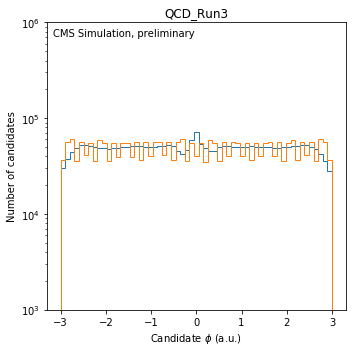

In [60]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(-3, 3, 60)
plt.hist(pm[pi!=0, 2], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 2], bins=bins, histtype="step", lw=1);
plt.yscale("log")
plt.ylim(1000, 1e6)

plt.xlabel("Candidate $\phi$ (a.u.)")
plt.ylabel("Number of candidates")
plt.title("QCD_Run3")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("phi_hist.pdf")

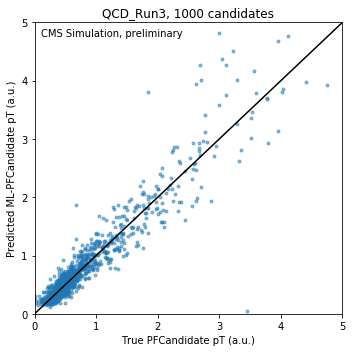

In [61]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

subidx = np.where((pi!=0)&(ti!=0))[0]
rp = np.random.permutation(range(len(subidx)))[:1000]

plt.scatter(pm[subidx[rp], 0], tm[subidx[rp], 0], marker=".", alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0,10],[0,10], color="black")

plt.xlabel("True PFCandidate pT (a.u.)")
plt.ylabel("Predicted ML-PFCandidate pT (a.u.)")
plt.title("QCD_Run3, 1000 candidates")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("pt_corr.pdf")

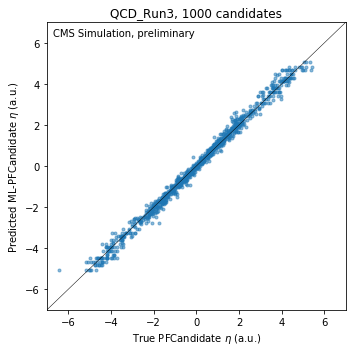

In [62]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-7, 7], [-7, 7], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 1], tm[subidx[rp], 1], marker=".", alpha=0.5)
plt.xlim(-7, 7)
plt.ylim(-7, 7)

plt.xlabel("True PFCandidate $\eta$ (a.u.)")
plt.ylabel("Predicted ML-PFCandidate $\eta$ (a.u.)")
plt.title("QCD_Run3, 1000 candidates")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("eta_corr.pdf")

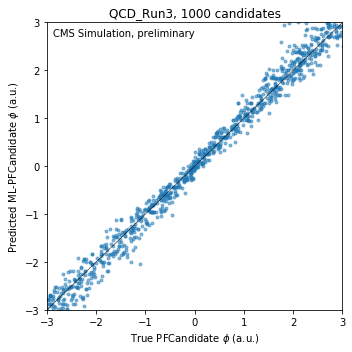

In [63]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-5, 5], [-5, 5], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 2], tm[subidx[rp], 2], marker=".", alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)


plt.xlabel("True PFCandidate $\phi$ (a.u.)")
plt.ylabel("Predicted ML-PFCandidate $\phi$ (a.u.)")
plt.title("QCD_Run3, 1000 candidates")
plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
plt.tight_layout()
plt.savefig("phi_corr.pdf")